## Introduction to Data Science

### Exploratory Data Analysis - Dimensionality Reduction and Feature Importance

based on [this](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/) post  

Introduction

Working on a dataset with many (thousand) features is a very challenging task, especially if you don’t know where to start! 
Having a high number of variables is both a boon and a curse. It’s great that we have loads of data for analysis, but it is challenging due to size.  

It’s not feasible to analyze each and every variable at a microscopic level. It might take us days or months to perform any meaningful analysis and we’ll lose a ton of time and money for our business! Not to mention the amount of computational power this will take. We need a better way to deal with high dimensional data so that we can quickly extract patterns and insights from it. So how do we approach such a dataset?  
Using dimensionality reduction techniques, of course. You can use this concept to reduce the number of features in your dataset without having to lose much information and keep (or improve) the model’s performance. It’s a really powerful way to deal with huge datasets.

This is a comprehensive guide to various dimensionality reduction techniques that can be used in practical scenarios.

In [1]:
import os
import sys
from glob import glob
import time
import pickle
import itertools
import zipfile

import pandas as pd
import numpy as np
import pylab
import cv2  #https://docs.opencv.org/3.4.1/d2/de6/tutorial_py_setup_in_ubuntu.html

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline

In [2]:
datapath = "../datasets/"
outputs = "../outputs/"

Table of Contents  

+ What is Dimensionality Reduction?  
+ Why is Dimensionality Reduction required?  
+ Common Dimensionality Reduction Techniques  
    + Missing Value Ratio  
    + Low Variance Filter  
    + High Correlation Filter  
    + Random Forest  
    + Backward Feature Elimination  
    + Forward Feature Selection  
    + Factor Analysis  
    + Principal Component Analysis (PCA)  
    + Singular Value Decomposition (SVD)
    + Independent Component Analysis (ICA)  
    + Methods Based on Projections  
    + t-Distributed Stochastic Neighbor Embedding (t-SNE)  
    + Uniform Manifold Approximation and Projection (UMAP)    
+ Feature importances by Permutation importances  

### 1. What is Dimensionality Reduction?

We are generating a tremendous amount of data daily. In fact, 90% of the data in the world has been generated in the last 3-4 years! The numbers are truly mind boggling. Below are just some of the examples of the kind of data being collected:

+ Facebook collects data of what you like, share, post, places you visit, restaurants you like, etc.
+ Your smartphone apps collect a lot of personal information about you
+ Amazon collects data of what you buy, view, click, etc. on their site
+ Casinos keep a track of every move each customer makes

As data generation and collection keeps increasing, visualizing it and drawing inferences becomes more and more challenging. One of the most common ways of doing visualization is through charts. Suppose we have 2 variables, Age and Height. We can use a scatter or line plot between Age and Height and visualize their relationship easily:

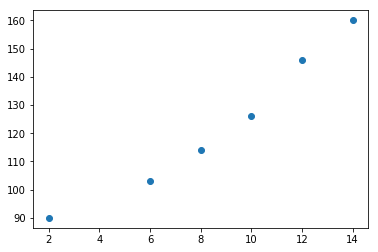

In [3]:
age = [2,6,8,10,12,14]
height = [90,103,114,126,146,160]
plt.scatter(age,height)

Now consider a case in which we have, say 100 variables (p=100). In this case, we can have 100(100-1)/2 = 5000 different plots. It does not make much sense to visualize each of them separately, right? In such cases where we have a large number of variables, it is better to select a subset of these variables (p<<100) which captures as much information as the original set of variables.

Let us understand this with a simple example. Consider the below image:

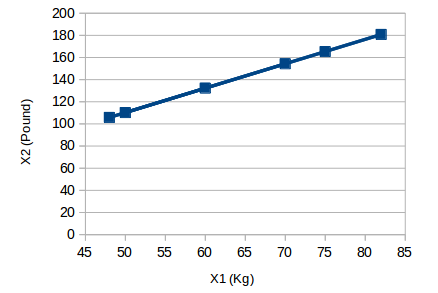

In [4]:
Image(filename='../datasets/Figs/sample_graph.png')

Here we have weights of similar objects in Kg (X1) and Pound (X2). If we use both of these variables, they will convey similar information. So, it would make sense to use only one variable. We can convert the data from 2D (X1 and X2) to 1D (Y1) as shown below:

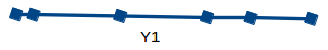

In [5]:
Image(filename='../datasets/Figs/straight_line.png')

Similarly, we can reduce p dimensions of the data into a subset of k dimensions (k<<n). This is called dimensionality reduction.

### 2. Why is Dimensionality Reduction required?

Here are some of the benefits of applying dimensionality reduction to a dataset:

+ Space required to store the data is reduced as the number of dimensions comes down
+ Less dimensions lead to less computation/training time
+ Some algorithms do not perform well when we have a large dimensions. So reducing these dimensions needs to happen for the algorithm to be useful
+ It takes care of multicollinearity by removing redundant features. For example, you have two variables – ‘time spent on treadmill in minutes’ and ‘calories burnt’. These variables are highly correlated as the more time you spend running on a treadmill, the more calories you will burn. Hence, there is no point in storing both as just one of them does what you require
+ It helps in visualizing data. As discussed earlier, it is very difficult to visualize data in higher dimensions so reducing our space to 2D or 3D may allow us to plot and observe patterns more clearly

### 3. Common Dimensionality Reduction Techniques

Dimensionality reduction can be done in two different ways:

+ Feature Selection - By only keeping the most relevant variables from the original dataset
+ Dimensionality Reduction - By finding a smaller set of new variables, each being a combination of the input variables, containing basically the same information as the input variables 

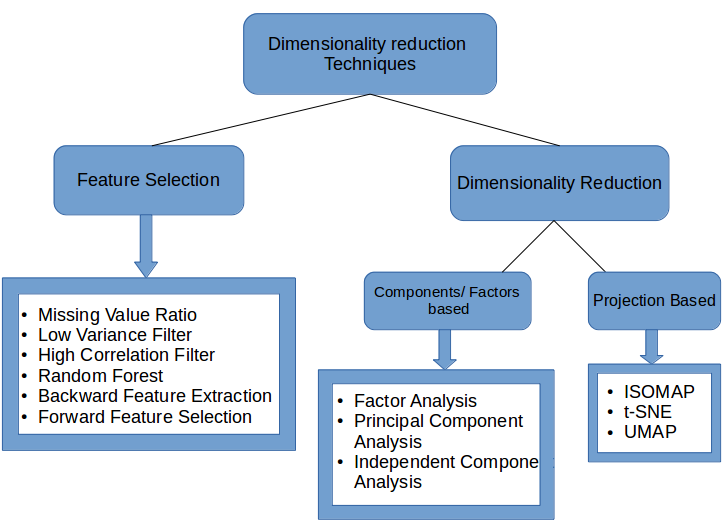

In [6]:
Image(filename='../datasets/Figs/dimreduxsummary.png')

+ Missing Value Ratio: If the dataset has too many missing values, we use this approach to reduce the number of variables. We can drop the variables having a large number of missing values in them
+ Low Variance filter: We apply this approach to identify and drop constant variables from the dataset. The target variable is not unduly affected by variables with low variance, and hence these variables can be safely dropped
+ High Correlation filter: A pair of variables having high correlation increases multicollinearity in the dataset. So, we can use this technique to find highly correlated features and drop them accordingly
+ Random Forest: This is one of the most commonly used techniques which tells us the importance of each feature present in the dataset. We can find the importance of each feature and keep the top most features, resulting in dimensionality reduction
+ Both Backward Feature Elimination and Forward Feature Selection techniques take a lot of computational time and are thus generally used on smaller datasets
+ Factor Analysis: This technique is best suited for situations where we have highly correlated set of variables. It divides the variables based on their correlation into different groups, and represents each group with a factor
+ Principal Component Analysis: This is one of the most widely used techniques for dealing with linear data. It divides the data into a set of components which try to explain as much variance as possible
+ Independent Component Analysis: We can use ICA to transform the data into independent components which describe the data using less number of components
+ ISOMAP: We use this technique when the data is strongly non-linear
+ t-SNE: This technique also works well when the data is strongly non-linear. It works extremely well for visualizations as well
+ UMAP: This technique works well for high dimensional data. Its run-time is shorter as compared to t-SNE

For the first part, we will be using [this](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/) dataset.

#### 3.1 Missing Value Ratio

Suppose you’re given a dataset. What would be your first step? You would naturally want to explore the data first before building model. While exploring the data, you find that your dataset has some missing values. Now what? You will try to find out the reason for these missing values and then impute them or drop the variables entirely which have missing values (using appropriate methods).

What if we have too many missing values (say more than 50%)? Should we impute the missing values or drop the variable? I would prefer to drop the variable since it will not have much information. However, this isn’t set in stone. We can set a threshold value and if the percentage of missing values in any variable is more than that threshold, we will drop the variable.

In [7]:
df_train = pd.read_csv(os.path.join(datapath,'CSVs/BigMart_Train.csv'))
df_test = pd.read_csv(os.path.join(datapath,'CSVs/BigMart_Test.csv'))

In [8]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [10]:
# checking the percentage of missing values in each variable
df_train.isnull().sum()/len(df_train)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [11]:
# saving missing values in a variable
a = df_train.isnull().sum()/len(df_train)*100

# saving column names in a variable
variables = df_train.columns
variable = [ ]
for i in range(0,12):
    if a[i]<=20:   #setting the threshold as 20%
        variable.append(variables[i])

df_train[variable].isnull().sum()/len(df_train)*100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

#### 3.2 Low Variance Filter

Consider a variable in our dataset where all the observations have the same value, say 1. If we use this variable, do you think it can improve the model we will build? The answer is no, because this variable will have zero variance.

So, we need to calculate the variance of each variable we are given. Then drop the variables having low variance as compared to other variables in our dataset. The reason for doing this, as I mentioned above, is that variables with a low variance will not affect the target variable.

Let’s first impute the missing values in the Item_Weight column using the median value of the known Item_Weight observations. For the Outlet_Size column, we will use the mode of the known Outlet_Size values to impute the missing values:

In [12]:
df_train['Item_Weight'].fillna(df_train['Item_Weight'].median(), inplace=True)
df_train['Outlet_Size'].fillna(df_train['Outlet_Size'].mode()[0], inplace=True)

Let’s check whether all the missing values have been filled:

In [13]:
df_train[variable].isnull().sum()/len(df_train)*100

Item_Identifier              0.0
Item_Weight                  0.0
Item_Fat_Content             0.0
Item_Visibility              0.0
Item_Type                    0.0
Item_MRP                     0.0
Outlet_Identifier            0.0
Outlet_Establishment_Year    0.0
Outlet_Location_Type         0.0
Outlet_Type                  0.0
Item_Outlet_Sales            0.0
dtype: float64

Voila! We are all set. Now let’s calculate the variance of all the numerical variables.

In [14]:
df_train.var()

Item_Weight                  1.786956e+01
Item_Visibility              2.662335e-03
Item_MRP                     3.878184e+03
Outlet_Establishment_Year    7.008637e+01
Item_Outlet_Sales            2.912141e+06
dtype: float64

As the above output shows, the variance of Item_Visibility is very less as compared to the other variables. We can safely drop this column. This is how we apply low variance filter.

In [15]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df_train.select_dtypes(include=numerics).columns
print(numeric_columns)

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')


In [16]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(0.10))
sel.fit_transform(df_train[numeric_columns])
sel.get_support()

array([ True, False,  True,  True,  True])

In [17]:
numeric_columns_highvar = np.array(numeric_columns)[sel.get_support()]
numeric_columns_highvar

array(['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year',
       'Item_Outlet_Sales'], dtype=object)

In [18]:
df_train[numeric_columns_highvar].head()

,Item_Weight,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.30,249.8092,1999,3735.1380
1,5.92,48.2692,2009,443.4228
2,17.50,141.6180,1999,2097.2700
3,19.20,182.0950,1998,732.3800
4,8.93,53.8614,1987,994.7052


#### 3.3 High Correlation filter

High correlation between two variables means they have similar trends and are likely to carry similar information. This can bring down the performance of some models drastically (linear and logistic regression models, for instance). We can calculate the correlation between independent numerical variables that are numerical in nature. If the correlation coefficient crosses a certain threshold value, we can drop one of the variables (dropping a variable is highly subjective and should always be done keeping the domain in mind).

As a general guideline, we should keep those variables which show a decent or high correlation with the target variable.

Let’s perform the correlation calculation in Python. We will drop the dependent variable (Item_Outlet_Sales) first and save the remaining variables in a new dataframe.  

In [19]:
df_train_X = df_train.drop('Item_Outlet_Sales', 1)
df_train_X.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
Item_Weight,1.000000,-0.014168,0.024951,0.007739
Item_Visibility,-0.014168,1.000000,-0.001315,-0.074834
Item_MRP,0.024951,-0.001315,1.000000,0.005020
Outlet_Establishment_Year,0.007739,-0.074834,0.005020,1.000000


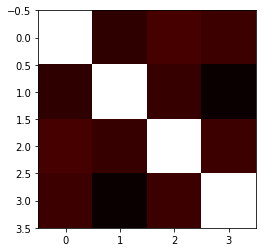

In [20]:
plt.imshow(df_train_X.corr(),cmap='hot',interpolation='nearest')

Wonderful, we don’t have any variables with a high correlation in our dataset. Generally, if the correlation between a pair of variables is greater than 0.5-0.6, we should seriously consider dropping one of those variables.

#### 3.4 Random Forest

Random Forest is one of the most widely used algorithms for feature selection. It comes packaged with in-built feature importance so you don’t need to program that separately. This helps us select a smaller subset of features.

We need to convert the data into numeric form by applying one hot encoding, as Random Forest (Scikit-Learn Implementation) takes only numeric inputs. Let’s also drop the ID variables (Item_Identifier and Outlet_Identifier) as these are just unique numbers and hold no significant importance for us currently.

In [21]:
from sklearn.ensemble import RandomForestRegressor
df_train_X.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)
model = RandomForestRegressor(random_state=1, max_depth=10)
df_train_X=pd.get_dummies(df_train_X)
model.fit(df_train_X,df_train.Item_Outlet_Sales)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

After fitting the model, plot the feature importance graph:

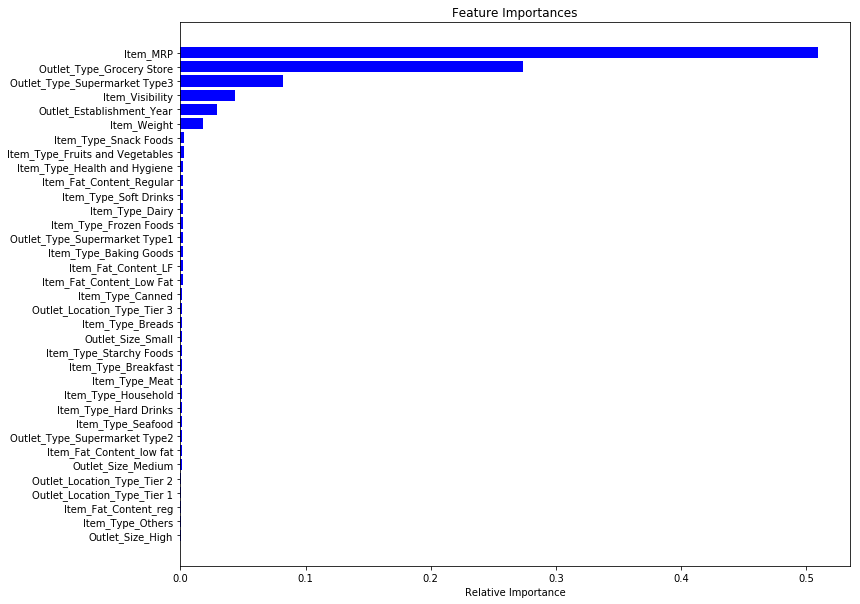

In [22]:
features = df_train_X.columns
importances = model.feature_importances_
indices = np.argsort(importances) #[0:9])  # top 10 features
plt.figure(figsize=(12,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Based on the above graph, we can hand pick the top-most features to reduce the dimensionality in our dataset. 
Alternatively, we can use the [SelectFromModel](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel) of sklearn to do so. It selects the features based on the importance of their weights.

In [23]:
from sklearn.feature_selection import SelectFromModel
new_model = SelectFromModel(model)
fit = new_model.fit_transform(df_train_X, df_train.Item_Outlet_Sales)

In [24]:
new_model.get_support()

array([False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True])

In [25]:
selected_columns = np.array(df_train_X.columns)[new_model.get_support()]
selected_columns

array(['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year',
       'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type3'],
      dtype=object)

In [26]:
df_train_X[selected_columns].head()

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3
0,0.016047,249.8092,1999,0,0
1,0.019278,48.2692,2009,0,0
2,0.016760,141.6180,1999,0,0
3,0.000000,182.0950,1998,1,0
4,0.000000,53.8614,1987,0,0


#### 3.5 Backward Feature Elimination

Follow the below steps to understand and use the ‘Backward Feature Elimination’ technique:

+ We first take all the n variables present in our dataset and train the model using them
+ We then calculate the performance of the model
+ Now, we compute the performance of the model after eliminating each variable (n times), i.e., we drop one variable every time and train the model on the remaining n-1 variables
+ We identify the variable whose removal has produced the smallest (or no) change in the performance of the model, and then drop that variable
+ Repeat this process until no variable can be dropped

This method can be used when building Linear Regression or Logistic Regression models. 

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import datasets

lreg = LinearRegression()
rfe = RFE(lreg, 10)

features = rfe.fit_transform(df_train_X, df_train.Item_Outlet_Sales)

We need to specify the algorithm and number of features to select, and we get back the list of variables obtained from backward feature elimination. We can also check the ranking of the variables using the “rfe.ranking_” command.

In [28]:
rfe.n_features_

10

In [29]:
rfe.ranking_

array([25,  1, 16, 14,  6, 24,  5, 11,  1, 19, 23, 22, 10,  2, 15,  1, 21,
       17,  3, 20,  1,  1, 18,  1,  1,  9, 13,  7, 12, 26,  8,  1,  1,  4,
        1])

The value of 1 (one) is assigned to all the relevant variables. We can check the chosen variables:

In [30]:
ranking = [(key,value) for key,value in sorted(dict(zip(df_train_X.columns, rfe.ranking_)).items(), key=lambda x: x[1])]
ranking[0:13]

[('Item_Visibility', 1),
 ('Item_Fat_Content_reg', 1),
 ('Item_Type_Fruits and Vegetables', 1),
 ('Item_Type_Others', 1),
 ('Item_Type_Seafood', 1),
 ('Item_Type_Soft Drinks', 1),
 ('Item_Type_Starchy Foods', 1),
 ('Outlet_Type_Grocery Store', 1),
 ('Outlet_Type_Supermarket Type1', 1),
 ('Outlet_Type_Supermarket Type3', 1),
 ('Item_Type_Dairy', 2),
 ('Item_Type_Household', 3),
 ('Outlet_Type_Supermarket Type2', 4)]

#### 3.6 Forward Feature Selection

This is the opposite process of the Backward Feature Elimination we saw above. Instead of eliminating features, we try to find the best features which improve the performance of the model. This technique works as follows:

+ We start with a single feature. Essentially, we train the model n number of times using each feature separately
+ The variable giving the best performance is selected as the starting variable
+ Then we repeat this process and add one variable at a time. The variable that produces the highest increase in performance is retained
+ We repeat this process until no significant improvement is seen in the model’s performance

In [31]:
from sklearn.feature_selection import f_regression
ffs = f_regression(df_train_X, df_train.Item_Outlet_Sales)

This returns an array containing the [F-values](http://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/) of the variables and the p-values corresponding to each F value.  
For our purpose, we will select the variables having F-value greater than 10:  

In [32]:
variable = []
for i in range(0,len(df_train_X.columns)-1):
    if ffs[0][i] >=10:
       variable.append(df_train_X.columns[i])

for v in variable:
    print(v)

Item_Visibility
Item_MRP
Outlet_Establishment_Year
Item_Type_Baking Goods
Outlet_Size_Medium
Outlet_Size_Small
Outlet_Location_Type_Tier 1
Outlet_Location_Type_Tier 2
Outlet_Location_Type_Tier 3
Outlet_Type_Grocery Store
Outlet_Type_Supermarket Type1
Outlet_Type_Supermarket Type2


This gives us the top most variables based on the forward feature selection algorithm.

NOTE : Both Backward Feature Elimination and Forward Feature Selection are time consuming and computationally expensive. They are practically only used on datasets that have a small number of input variables.

---  

The techniques we have seen so far are generally used when we do not have a very large number of variables in our dataset. These are more or less feature selection techniques. In the upcoming sections, we will be working with the Fashion MNIST dataset, which consists of images belonging to different types of apparel, e.g. T-shirt, trousers, bag, etc. The dataset can be downloaded from the ["identify the apparel"](https://datahack.analyticsvidhya.com/contest/practice-problem-identify-the-apparels/) practice problem.

The dataset has a total of 70,000 images, out of which 60,000 are in the training set and the remaining 10,000 are test images. We will be working only on the training images. The train file is in a zip format. Once you extract the zip file, you will get a .csv file and a train folder which includes these 60,000 images. The corresponding label of each image can be found in the ‘train.csv’ file.

Let’s first extract from zip and read in all the images contained in the train folder:

if the images are already extracted:

In [33]:
images = [cv2.imread(file) for file in glob('../outputs/train/*.png')]
images = np.array(images)
images.shape

(60000, 28, 28, 3)

In [34]:
images[0,:,:].shape

(28, 28, 3)

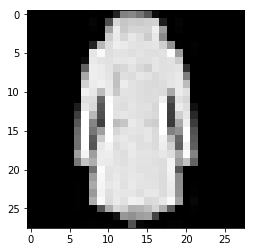

In [35]:
plt.imshow(images[0,:,:,:], interpolation='nearest')

As you can see above, it’s a 3-dimensional array. We must convert it to 1-dimension as all the upcoming techniques only take 1-dimensional input.  
To do this, we need to flatten the images:

In [36]:
image = []
for i in range(0,60000):
    img = images[i].flatten()
    image.append(img)
image = np.array(image)

image.shape

(60000, 2352)

Let us now create a dataframe containing the pixel values of every individual pixel present in each image, and also their corresponding labels

In [37]:
with zipfile.ZipFile("../datasets/AVidhya/Train_FashionApparel.zip", 'r') as myzip:
    with myzip.open('train.csv') as myfile:
        labels = pd.read_csv(myfile)
#labels.set_index('id', drop=True, inplace=True)
labels.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [38]:
feat_cols = ['pixel_'+str(i) for i in range(image.shape[1]) ]
df = pd.DataFrame(image,columns=feat_cols)
df['label'] = labels['label']
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_2343,pixel_2344,pixel_2345,pixel_2346,pixel_2347,pixel_2348,pixel_2349,pixel_2350,pixel_2351,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Before moving further, we’ll randomly plot some of the images from our dataset:

<Figure size 432x288 with 0 Axes>

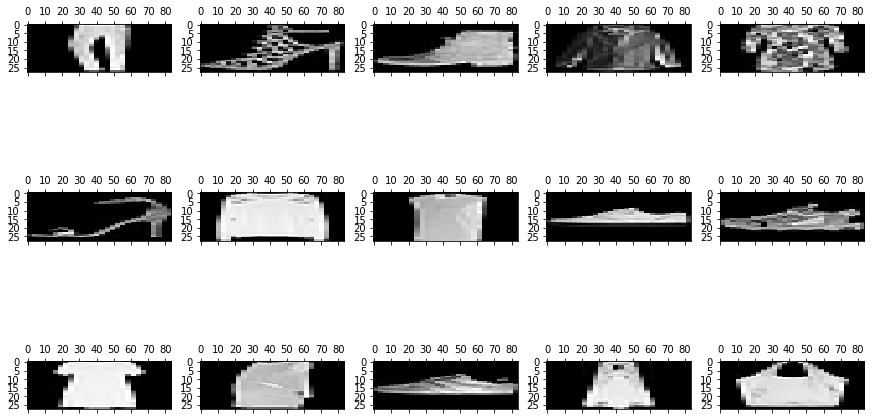

In [39]:
rndperm = np.random.permutation(df.shape[0])
plt.gray()
fig = plt.figure(figsize=(15,15))
for i in range(0,15):
    ax = fig.add_subplot(5,5,i+1)
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28*3)).astype(float))

Now we will show other techniques using this dataset:  

### 3.7 Factor Analysis

Suppose we have two variables: Income and Education. These variables will potentially have a high correlation as people with a higher education level tend to have significantly higher income, and vice versa.

In the Factor Analysis technique, variables are grouped by their correlations, i.e., all variables in a particular group will have a high correlation among themselves, but a low correlation with variables of other group(s). Here, each group is known as a factor. These factors are small in number as compared to the original dimensions of the data. However, these factors are difficult to observe.

In [40]:
from sklearn.decomposition import FactorAnalysis
FA = FactorAnalysis(n_components = 3).fit_transform(df[feat_cols].values)

Here, n_components will decide the number of factors in the transformed data. After transforming the data, it’s time to visualize the results:

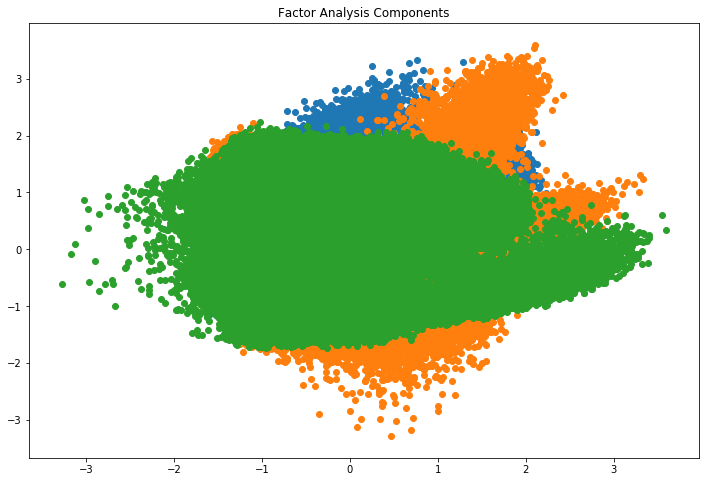

In [41]:
plt.figure(figsize=(12,8))
plt.title('Factor Analysis Components')
plt.scatter(FA[:,0], FA[:,1])
plt.scatter(FA[:,1], FA[:,2])
plt.scatter(FA[:,2],FA[:,0])

We can see all the different factors in the above graph. Here, the x-axis and y-axis represent the values of decomposed factors.  
It is hard to observe these factors individually but we have been able to reduce the dimensions of our data successfully.  

### 3.8 Principal Component Analysis (PCA)

[PCA](https://www.analyticsvidhya.com/blog/2017/05/comprehensive-guide-to-linear-algebra/) is a technique which helps us in extracting a new set of variables from an existing large set of variables. These newly extracted variables are called Principal Components. In a glance:

+ A principal component is a linear combination of the original variables
+ Principal components are extracted in such a way that the first principal component explains maximum variance in the dataset
+ Second principal component tries to explain the remaining variance in the dataset and is uncorrelated to the first principal component
+ Third principal component tries to explain the variance which is not explained by the first two principal components and so on

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(df[feat_cols].values)

In [43]:
pca_result.shape

(60000, 4)

In this case, n_components will decide the number of principal components in the transformed data.  
Let’s visualize how much variance has been explained using these 4 components.  
We will use explained_variance_ratio_ to calculate the same.

Text(0.5,1,'Component-wise and Cumulative Explained Variance')

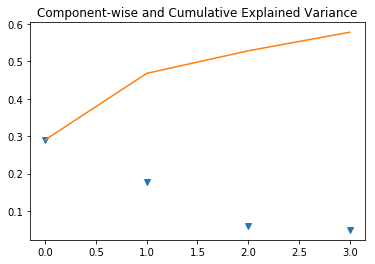

In [44]:
plt.plot(range(4), pca.explained_variance_ratio_, 'v')
plt.plot(range(4), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In the above graph, the blue line represents component-wise explained variance while the orange line represents the cumulative explained variance. We are able to explain around 60% variance in the dataset using just four components. Let us now try to visualize each of these decomposed components:  

Text(0.5,0.98,'4-Component PCA')

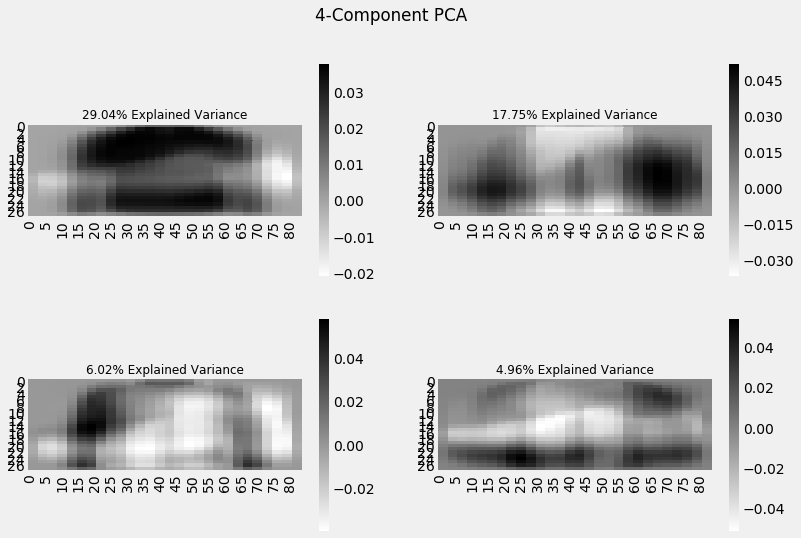

In [45]:
plt.style.use('fivethirtyeight')
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))

sns.heatmap(pca.components_[0, :].reshape(28, 84), ax=axarr[0][0], cmap='gray_r')
sns.heatmap(pca.components_[1, :].reshape(28, 84), ax=axarr[0][1], cmap='gray_r')
sns.heatmap(pca.components_[2, :].reshape(28, 84), ax=axarr[1][0], cmap='gray_r')
sns.heatmap(pca.components_[3, :].reshape(28, 84), ax=axarr[1][1], cmap='gray_r')

axarr[0][0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100),fontsize=12)
axarr[0][1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100),fontsize=12)
axarr[1][0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100),fontsize=12)
axarr[1][1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[3]*100),fontsize=12)
axarr[0][0].set_aspect('equal')
axarr[0][1].set_aspect('equal')
axarr[1][0].set_aspect('equal')
axarr[1][1].set_aspect('equal')

plt.suptitle('4-Component PCA')

Each additional dimension we add to the PCA technique captures less and less of the variance in the model.  
The first component is the most important one, followed by the second, then the third, and so on.   

### 3.9 Singular Value Decomposition  

We can also use [Singular Value Decomposition (SVD)](https://www.analyticsvidhya.com/blog/2017/05/comprehensive-guide-to-linear-algebra/) to decompose our original dataset into its constituents, resulting in dimensionality reduction. 

SVD decomposes the original variables into three constituent matrices. It is essentially used to remove redundant features from the dataset. It uses the concept of Eigenvalues and Eigenvectors to determine [those three matrices](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca).

Let’s implement SVD and decompose our original variables:

In [46]:
from sklearn.decomposition import TruncatedSVD 
svd = TruncatedSVD(n_components=3, random_state=42).fit_transform(df[feat_cols].values)

In [47]:
svd.shape

(60000, 3)

Let us visualize the transformed variables by plotting the first two principal components:

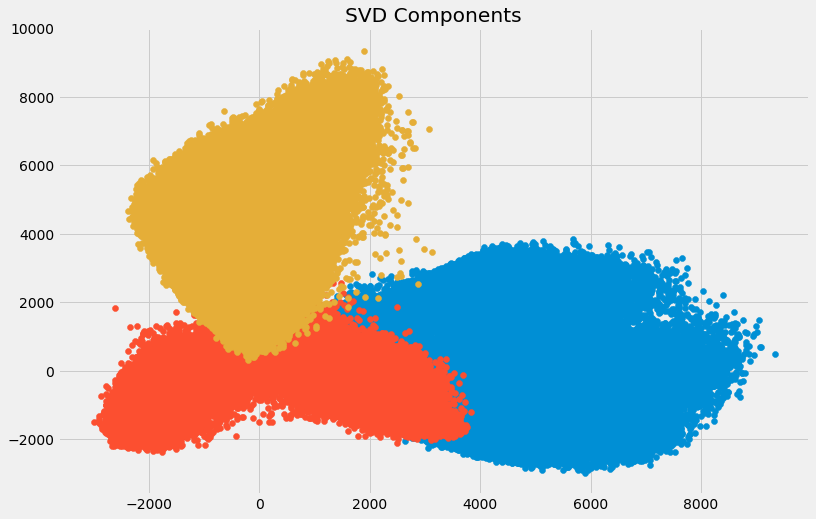

In [48]:
plt.figure(figsize=(12,8))
plt.title('SVD Components')
plt.scatter(svd[:,0], svd[:,1])
plt.scatter(svd[:,1], svd[:,2])
plt.scatter(svd[:,2],svd[:,0])

### 3.10 Independent Component Analysis

Independent Component Analysis (ICA) is based on information-theory and is also one of the most widely used dimensionality reduction techniques.  
The major difference between PCA and ICA is that PCA looks for uncorrelated factors while ICA looks for independent factors.

If two variables are uncorrelated, it means there is no linear relation between them. If they are independent, it means they are not dependent on other variables.  
For example, the age of a person is independent of what that person eats, or how much television he/she watches.

This algorithm assumes that the given variables are linear mixtures of some unknown latent variables. It also assumes that these latent variables are mutually independent, i.e., they are not dependent on other variables and hence they are called the independent components of the observed data.

Let’s compare PCA and ICA visually to get a better understanding of how they are different:

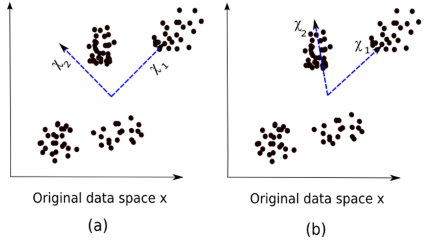

In [49]:
Image(filename='../datasets/Figs/pca_ica.png')

Here, image (a) represents the PCA results while image (b) represents the ICA results on the same dataset.  
The equation of PCA is x = Wχ.
Here,

+ x is the observations
+ W is the mixing matrix
+ χ is the source or the independent components

Now we have to find an un-mixing matrix such that the components become as independent as possible.  
Most common method to measure independence of components is Non-Gaussianity:  

As per the central limit theorem, distribution of the sum of independent components tends to be normally distributed (Gaussian).  

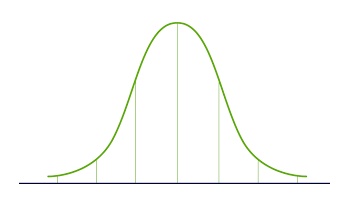

In [50]:
Image(filename='../datasets/Figs/pca_ica2.png')

+ So we can look for the transformations that maximize the kurtosis of each component of the independent components. [Kurtosis](https://brownmath.com/stat/shape.htm#Kurtosis) is the third order moment of the distribution.
+ Maximizing the kurtosis will make the distribution non-gaussian and hence we will get independent components.

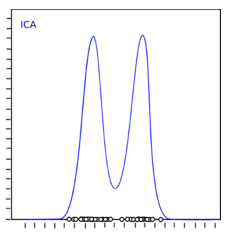

In [51]:
Image(filename='../datasets/Figs/pca_ica3.png')

The above distribution is non-gaussian which in turn makes the components independent.  
Let’s implement ICA:

In [52]:
from sklearn.decomposition import FastICA 
ICA = FastICA(n_components=3, random_state=12) 
X=ICA.fit_transform(df[feat_cols].values)

Here, n_components will decide the number of components in the transformed data. We have transformed the data into 3 components using ICA.  

In [53]:
X.shape

(60000, 3)

Let’s visualize how well it has transformed the data:

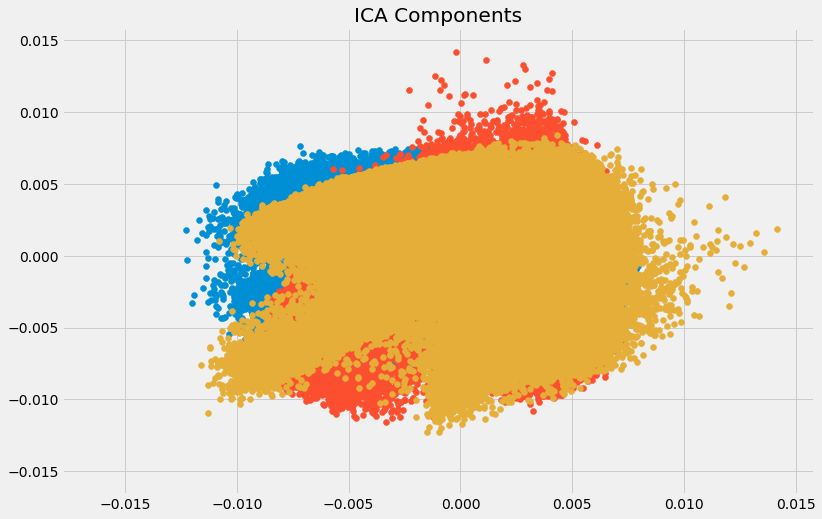

In [54]:
plt.figure(figsize=(12,8))
plt.title('ICA Components')
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[:,1], X[:,2])
plt.scatter(X[:,2], X[:,0])

The data has been separated into different independent components which can be seen very clearly in the above image. X-axis and Y-axis represent the value of decomposed independent components.

Now we shall look at some of the methods which reduce the dimensions of the data using projection techniques.

### 3.11 Methods Based on Projections

To start off, we need to understand what projection is. Suppose we have two vectors, vector a and vector b, as shown below:

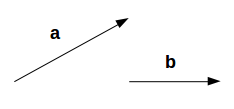

In [55]:
Image(filename='../datasets/Figs/project1.png')

We want to find the projection of a on b. Let the angle between a and b be ∅. The projection (a1) will look like:

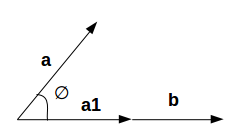

In [56]:
Image(filename='../datasets/Figs/project2.png')

a1 is the vector parallel to b. So, we can get the projection of vector a on vector b using the below equation:

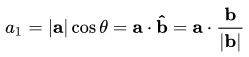

In [57]:
Image(filename='../datasets/Figs/project3.png')

Here,

+ a1 = projection of a onto b  
+ b̂ = unit vector in the direction of b  

By projecting one vector onto the other, dimensionality can be reduced.  

In projection techniques, multi-dimensional data is represented by projecting its points onto a lower-dimensional space. Now we will discuss different methods of projections:  

+ Projection onto interesting directions:
    + Interesting directions depend on specific problems but generally, directions in which the projected values are non-gaussian are considered to be interesting  
    + Similar to ICA (Independent Component Analysis), projection looks for directions maximizing the kurtosis of the projected values as a measure of non-gaussianity  


+ Projection onto Manifolds:  

Once upon a time, it was assumed that the Earth was flat. No matter where you go on Earth, it keeps looking flat (let’s ignore the mountains for a while). But if you keep walking in one direction, you will end up where you started. That wouldn’t happen if the Earth was flat. The Earth only looks flat because we are minuscule as compared to the size of the Earth.  

These small portions where the Earth looks flat are manifolds, and if we combine all these manifolds we get a large scale view of the Earth, i.e., original data. Similarly for an n-dimensional curve, small flat pieces are manifolds and a combination of these manifolds will give us the original n-dimensional curve. Let us look at the steps for projection onto manifolds:

+ We first look for a manifold that is close to the data
+ Then project the data onto that manifold
+ Finally for representation, we unfold the manifold
+ There are various techniques to get the manifold, and all of these techniques consist of a three-step approach:  
    + Collecting information from each data point to construct a graph having data points as vertices  
    + Transforming the above generated graph into suitable input for embedding steps  
    + Computing an (nXn) eigen equation  

Let us understand manifold projection technique with an example.  

If a manifold is continuously differentiable to any order, it is known as smooth or differentiable manifold. ISOMAP is an algorithm which aims to recover full low-dimensional representation of a non-linear manifold. It assumes that the manifold is smooth.  

It also assumes that for any pair of points on manifold, the geodesic distance (shortest distance between two points on a curved surface) between the two points is equal to the Euclidean distance (shortest distance between two points on a straight line). Let’s first visualize the geodesic and Euclidean distance between a pair of points:

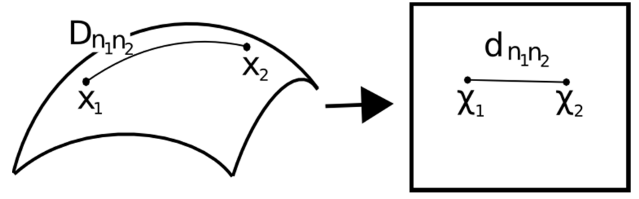

In [58]:
Image(filename='../datasets/Figs/project4.png')

Here,

+ $Dn_1n_2$ = geodesic distance between $X_1$ and $X_2$
+ $dn_1n_2$ = Euclidean distance between $χ_1$ and $χ_2$

ISOMAP assumes both of these distances to be equal. Let’s now look at a more detailed explanation of this technique. As mentioned earlier, all these techniques work on a three-step approach. We will look at each of these steps in detail:  

+ Neighborhood Graph:  
    + First step is to calculate the distance between all pairs of data points:  
    + $d_{ij} = d_χ(x_i,x_j) = || x_i-x_j || χ$  
Here,  
    + $d_χ(x_i,x_j) =$ geodesic distance between $x_i$ and $x_j $ 
    + $|| x_i-x_j || =$ Euclidean distance between $x_i$ and $x_j$  
    + After calculating the distance, we determine which data points are neighbors of manifold  
    + Finally the neighborhood graph is generated: $G=G(V,ℰ)$, where the set of vertices $V = {x_1, x_2,\ldots , x_n}$ are input data points and set of edges $ℰ = e_{ij}$ indicate neighborhood relationship between the points   


+ Compute Graph Distances:
    + Now we calculate the geodesic distance between pairs of points in manifold by graph distances
    + Graph distance is the shortest path distance between all pairs of points in graph G   


+ Embedding:  
    + Once we have the distances, we form a symmetric $(n{\times}n)$ matrix of squared graph distance  
    + Now we choose embedding vectors to minimize the difference between geodesic distance and graph distance  
    + Finally, the graph G is embedded into Y by the $(t{\times}n)$ matrix  

We will perform non-linear dimensionality reduction through Isometric Mapping.  
For visualization, we will only take a subset of our dataset as running it on the entire dataset will require a lot of time.

In [59]:
from sklearn import manifold 
trans_data = manifold.Isomap(n_neighbors=5, n_components=3, n_jobs=-1).fit_transform(df[feat_cols][:6000].values)

Parameters used:  
+ n_neighbors decides the number of neighbors for each point
+ n_components decides the number of coordinates for manifold
+ n_jobs = -1 will use all the CPU cores available

In [60]:
trans_data.shape

(6000, 3)

Visualizing the transformed data:

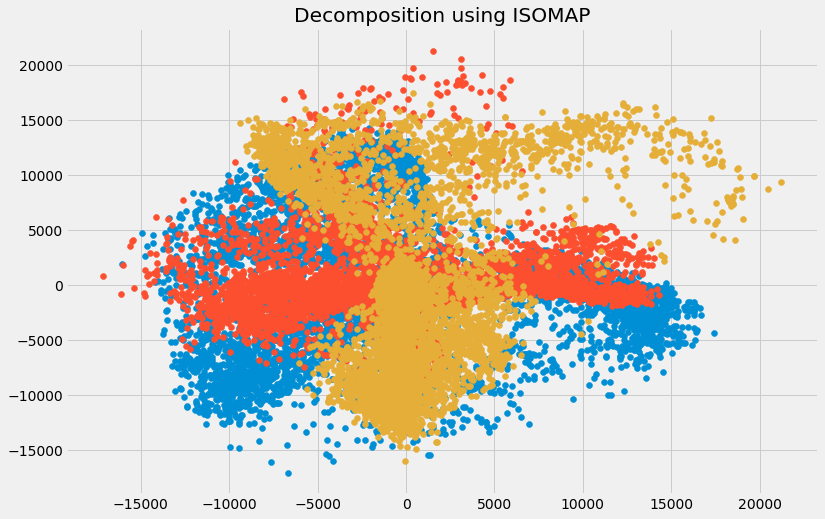

In [61]:
plt.figure(figsize=(12,8))
plt.title('Decomposition using ISOMAP')
plt.scatter(trans_data[:,0], trans_data[:,1])
plt.scatter(trans_data[:,1], trans_data[:,2])
plt.scatter(trans_data[:,2], trans_data[:,0])

### 3.12 t- Distributed Stochastic Neighbor Embedding (t-SNE)

So far we have learned that PCA is a good choice for dimensionality reduction and visualization for datasets with a large number of variables. But what if we could use something more advanced? What if we can easily search for patterns in a non-linear way? [t-SNE](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/) is one such technique. There are mainly two types of approaches we can use to map the data points:

+ Local approaches: They maps nearby points on the manifold to nearby points in the low dimensional representation.
+ Global approaches: They attempt to preserve geometry at all scales, i.e. mapping nearby points on manifold to nearby points in low dimensional representation as well as far away points to far away points.  

    + t-SNE is one of the few algorithms which is capable of retaining both local and global structure of the data at the same time  
    + It calculates the probability similarity of points in high dimensional space as well as in low dimensional space  
    + High-dimensional Euclidean distances between data points are converted into conditional probabilities that represent similarities:  

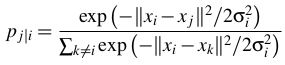

In [62]:
Image(filename='../datasets/Figs/tsne1.png')

xi and xj are data points, ||xi-xj|| represents the Euclidean distance between these data points, and 𝛔i is the variance of data points in high dimensional space  
+ For the low-dimensional data points yi and yj corresponding to the high-dimensional data points xi and xj, it is possible to compute a similar conditional probability using:

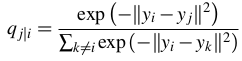

In [63]:
Image(filename='../datasets/Figs/tsne2.png')

where ||yi-yj|| represents the Euclidean distance between yi and yj  
+ After calculating both the probabilities, it minimizes the difference between both the probabilities

In [64]:
from sklearn.manifold import TSNE 
tsne = TSNE(n_components=3, n_iter=300).fit_transform(df[feat_cols][:6000].values)

n_components will decide the number of components in the transformed data. 

In [65]:
tsne.shape

(6000, 3)

Time to visualize the transformed data:

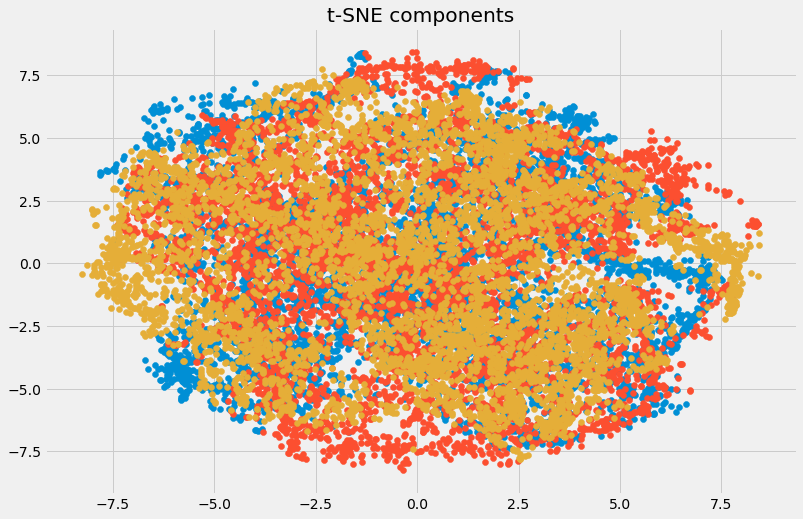

In [66]:
plt.figure(figsize=(12,8))
plt.title('t-SNE components')
plt.scatter(tsne[:,0], tsne[:,1])
plt.scatter(tsne[:,1], tsne[:,2])
plt.scatter(tsne[:,2], tsne[:,0])

Here you can clearly see the different components that have been transformed using the powerful t-SNE technique.

### 3.13 Uniform Manifold Approximation and Projection [(UMAP)](https://arxiv.org/pdf/1802.03426.pdf)

t-SNE works very well on large datasets but it also has it’s limitations, such as loss of large-scale information, slow computation time, and inability to meaningfully represent very large datasets. Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can preserve as much of the local, and more of the global data structure as compared to t-SNE, with a shorter runtime. Sounds intriguing, right?  

Some of the key advantages of UMAP are:  

+ It can handle large datasets and high dimensional data without too much difficulty  
+ It combines the power of visualization with the ability to reduce the dimensions of the data  
+ Along with preserving the local structure, it also preserves the global structure of the data. UMAP maps nearby points on the manifold to nearby points in the low dimensional representation, and does the same for far away points  

This method uses the concept of k-nearest neighbor and optimizes the results using stochastic gradient descent. It first calculates the distance between the points in high dimensional space, projects them onto the low dimensional space, and calculates the distance between points in this low dimensional space. It then uses Stochastic Gradient Descent to minimize the difference between these distances.  

In [67]:
# sudo pip3 install --upgrade umap-learn  

import umap
umap_data = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=3).fit_transform(df[feat_cols][:6000].values)

Here,
+ n_neighbors determines the number of neighboring points used  
+ min_dist controls how tightly embedding is allowed. Larger values ensure embedded points are more evenly distributed  

In [68]:
umap_data.shape

(6000, 3)

Let us visualize the transformation:  

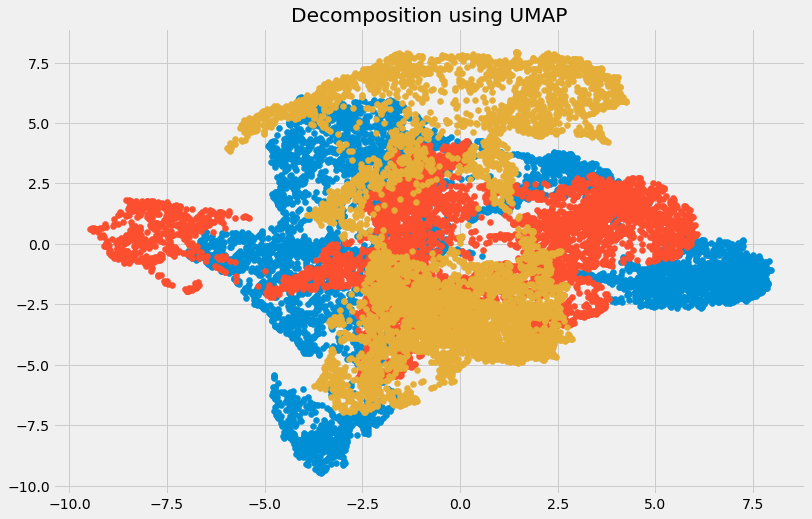

In [69]:
plt.figure(figsize=(12,8))
plt.title('Decomposition using UMAP')
plt.scatter(umap_data[:,0], umap_data[:,1])
plt.scatter(umap_data[:,1], umap_data[:,2])
plt.scatter(umap_data[:,2], umap_data[:,0])

The dimensions have been reduced and we can visualize the different transformed components. There is very less correlation between the transformed variables.  
We can see that the correlation between the components obtained from UMAP is quite less as compared to the correlation between the components obtained from t-SNE. Hence, UMAP tends to give better results.  

As mentioned in UMAP’s GitHub repository, it often performs better at preserving aspects of the global structure of the data than t-SNE. This means that it can often provide a better “big picture” view of the data as well as preserving local neighbor relations.  

### Feature Importances 
#### [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance/)

One of the most basic questions we might ask of a model is: What features have the biggest impact on predictions?  

This concept is called feature importance. There are multiple ways to measure feature importance. Some approaches answer subtly different versions of the question above. Other approaches have documented shortcomings.

We'll focus on permutation importance. Compared to most other approaches, permutation importance is:

+ Fast to calculate
+ Widely used and understood
+ Consistent with properties we would want a feature importance measure to have


Permutation importance is calculated after a model has been fitted. So we won't change the model or change what predictions we'd get for a given observation. Instead we will ask the following question: If I randomly shuffle a single column of the validation data, leaving the target and all other columns in place, how would that affect the accuracy of predictions in that now-shuffled data?  

Randomly re-ordering a single column should cause less accurate predictions, since the resulting data no longer corresponds to anything observed in the real world. Model accuracy especially suffers if we shuffle a column that the model relied on heavily for predictions.  
With this insight, the process is as follows:  

+ Get a trained model  
+ Shuffle the values in a single column, make predictions using the resulting dataset.  
+ Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.  
+ Return the data to the original order (undoing the shuffle from step 2.) 
+ Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.  


Let's get back to our firts dataset and the Random Forest Regressor:

In [70]:
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier

df_train_X = pd.get_dummies(df_train_X)
X_train, X_val, y_train , y_val = train_test_split(df_train_X.values, df_train.Item_Outlet_Sales, random_state=1)

In [71]:
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

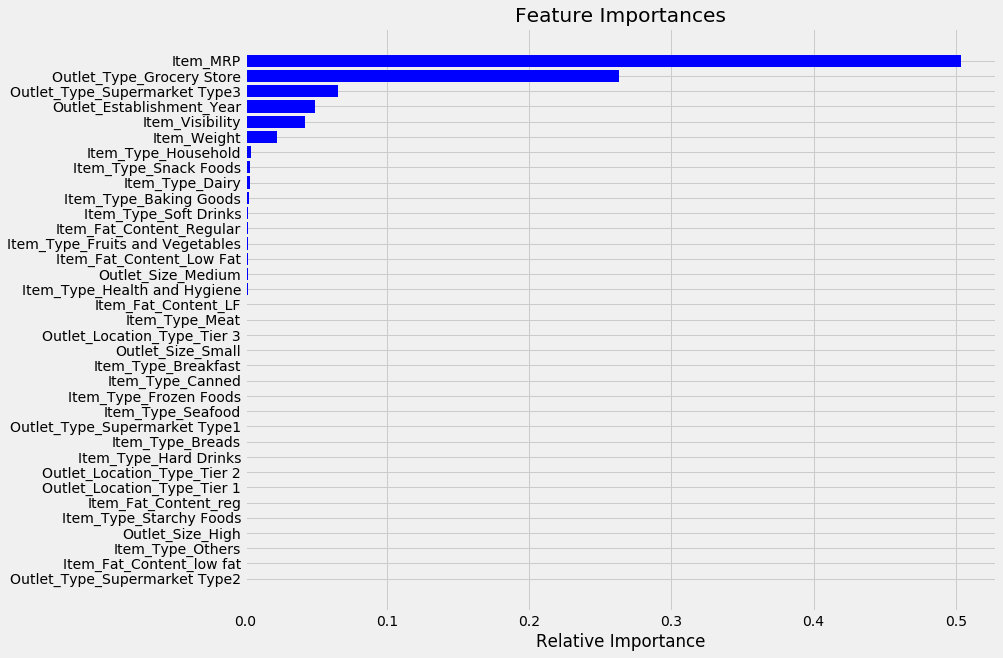

In [72]:
features = df_train_X.columns
importances = model.feature_importances_
indices = np.argsort(importances) #[0:9])  # top 10 features
plt.figure(figsize=(12,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Here is how to calculate and show importances with the eli5 library:

In [73]:
import eli5
from eli5.sklearn import PermutationImportance

In [75]:
perm = PermutationImportance(model, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = list(features))

Weight,Feature
0.7260 ± 0.0211,Item_MRP
0.4761 ± 0.0318,Outlet_Type_Grocery Store
0.0404 ± 0.0101,Outlet_Type_Supermarket Type3
0.0293 ± 0.0068,Outlet_Establishment_Year
0.0020 ± 0.0018,Outlet_Type_Supermarket Type1
0.0014 ± 0.0010,Outlet_Location_Type_Tier 3
0.0009 ± 0.0020,Item_Type_Fruits and Vegetables
0.0005 ± 0.0020,Item_Type_Soft Drinks
0.0003 ± 0.0013,Item_Fat_Content_Regular
0.0003 ± 0.0007,Outlet_Location_Type_Tier 1


### Interpreting Permutation Importances¶

The values towards the top are the most important features, and those towards the bottom matter least.  

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).  

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.  

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, because there is more room for luck/chance.  

If we compare the results with the Random Forest Regressor importances we see:

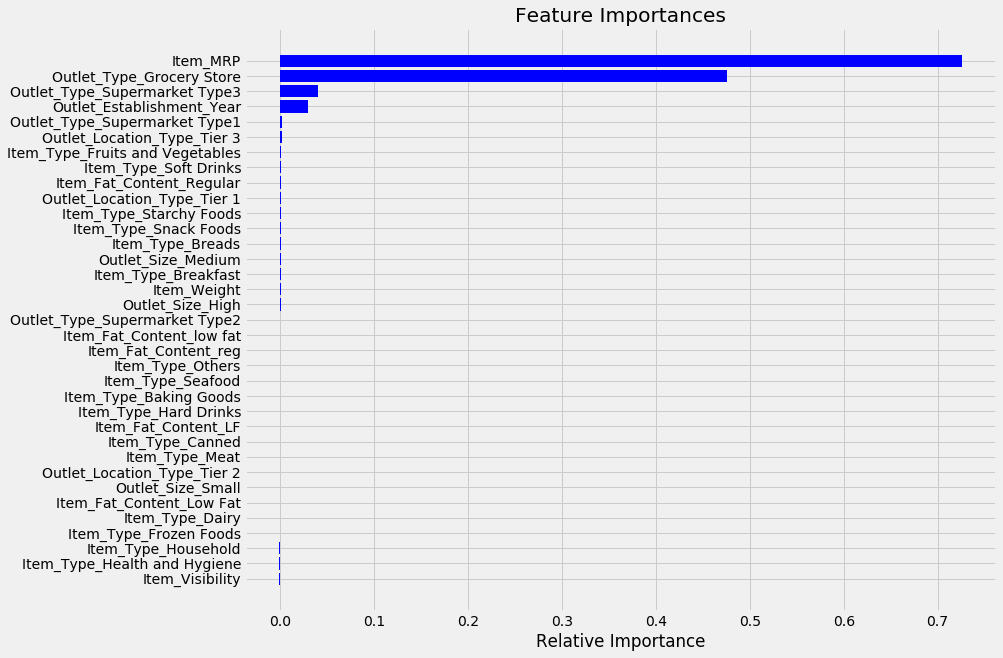

In [76]:
importances = perm.feature_importances_
indices = np.argsort(importances) #[0:9])  # top 10 features
plt.figure(figsize=(12,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()